In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch
from torch import Tensor, nn

In [4]:
from torch.utils.data import DataLoader

from soundgen.datasets import TinyPianoDataset
from soundgen.transformations.preprocess import PreprocessingModule

from soundgen.models.vae import VAELit
from soundgen.configs import TrainConfig, VAEConfig

In [5]:
from lightning import Trainer

In [6]:
from soundgen.transformations.postprocess import MelToWaveformTransform
from IPython.display import Audio, display


In [7]:
from librosa.display import specshow, waveshow

# Load data and check preprocessing

In [8]:
top_folder = Path().resolve().parent
print(top_folder)

/Users/borispodolnyi/Documents/coding_projects/soundgen


In [42]:
sr = 22050
num_samples = 22050  # to get 64x64 mel spectrograms

n_fft=512
n_mels=60

power = 2.

In [43]:
preprocessing = PreprocessingModule(sample_rate=sr, num_samples=num_samples, n_fft=n_fft, n_mels=n_mels, power=power)

dataset = TinyPianoDataset(top_folder / "data/tiny_piano", transform=preprocessing, target_sr=sr)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [44]:
X, sr, lbl = dataset[0]

In [45]:
waveform = dataset.get_audio(0)

In [46]:
X.shape

torch.Size([1, 60, 87])

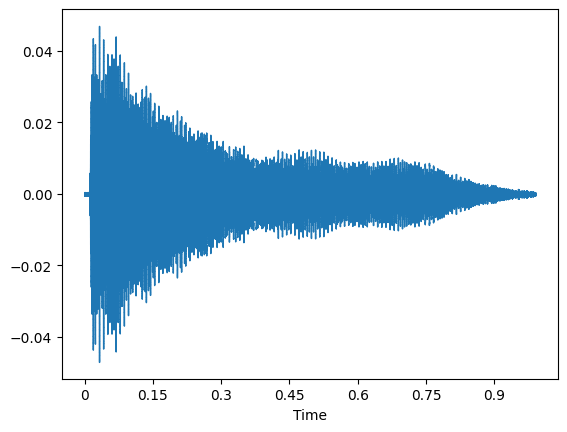

In [47]:
waveshow(waveform.numpy(), sr=sr)

In [48]:
X.min()

tensor(0.)

In [49]:
X.max()

tensor(1.)

In [50]:
preprocessing.s_min, preprocessing.s_max

(3.985965577157913e-06, 5683.69482421875)

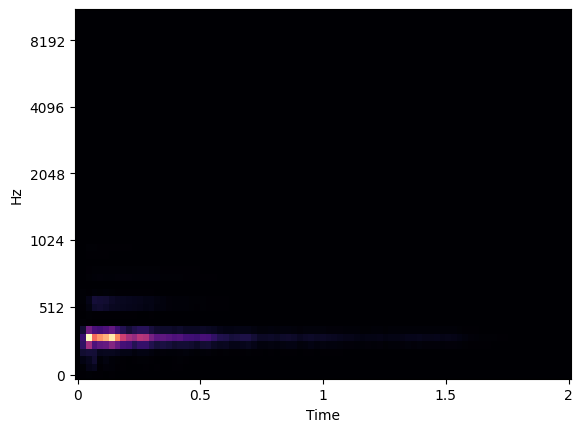

In [51]:
specshow(X.squeeze().detach().numpy(), sr=sr, x_axis='time', y_axis='mel')

In [52]:
s_max = preprocessing.s_max
s_max

5683.69482421875

In [57]:
reconstruct_transform = MelToWaveformTransform(sample_rate=sr, n_fft=n_fft, n_mels=n_mels, s_max=1, power=power)

In [58]:
wave_recon = reconstruct_transform(X.unsqueeze(0)).squeeze()

In [59]:
display(Audio(waveform, rate=sr))

In [60]:
display(Audio(wave_recon, rate=sr))

# Init VAE

In [24]:
# vae_config = VAEConfig.from_json(top_folder / "configs/vae_1d.json")
vae_config = VAEConfig(**{
    "input_shape": [1, 60, 87],
    "conv_filters_number": [128, 64, 32, 32, 16],
    "conv_kernel_size": [4, 4, 4, 3, 3],
    "conv_strides": [2, 2, 2, 1, 1],
    "latent_space_dim": 32,
    "shape_before_bottleneck": [16, 7, 10],

    "kl_weight": 0.001,
    "warmup_epochs": 20
})

In [25]:
# Create training configuration
train_config = TrainConfig(
    num_epochs=1000,
    learning_rate=0.0005,
    batch_size=19
)

In [26]:
# vae_config.input_shape = list(X.shape)

In [27]:
vae_lit = VAELit(learning_rate=train_config.learning_rate, **vae_config.to_dict())

# Training

## Set up

In [70]:
# Initialize trainer
# trainer = Trainer(max_epochs=train_config.num_epochs, gradient_clip_val=1.0)
trainer = Trainer(max_epochs=200, gradient_clip_val=1.0)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


## Run

In [71]:
%%time
trainer.fit(vae_lit, train_loader)


  | Name    | Type    | Params | Mode | FLOPs
---------------------------------------------------
0 | model   | VAE     | 469 K  | eval | 0    
1 | loss_fn | VAELoss | 0      | eval | 0    
---------------------------------------------------
469 K     Trainable params
0         Non-trainable params
469 K     Total params
1.879     Total estimated model params size (MB)
0         Modules in train mode
45        Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


CPU times: user 9 s, sys: 3.3 s, total: 12.3 s
Wall time: 25 s


# Generate sounds

## Load from checkpoint

In [30]:
# last ok 45

In [72]:
latest_log_version = sorted([int(f.name.split('_')[-1]) for f in list(Path('lightning_logs').glob('*'))])[-1]
latest_log_version

54

In [73]:
checkpoint_version = latest_log_version
checkpoint_files = list((top_folder / f"experiments/lightning_logs/version_{checkpoint_version}/checkpoints").glob("*.ckpt"))
checkpoint_file = checkpoint_files[0]
checkpoint_file

PosixPath('/Users/borispodolnyi/Documents/coding_projects/soundgen/experiments/lightning_logs/version_54/checkpoints/epoch=199-step=200.ckpt')

In [74]:
vae_lit = VAELit.load_from_checkpoint(checkpoint_file, **vae_config.to_dict())

## Reconstruct audio

In [75]:
vae_lit.to('cpu')

VAELit(
  (model): VAE(
    (encoder): Encoder(
      (mu): Linear(in_features=1120, out_features=32, bias=True)
      (log_var): Linear(in_features=1120, out_features=32, bias=True)
      (conv_layers): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
        (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): ReLU()
        (12)

In [76]:
vae_lit.eval()

VAELit(
  (model): VAE(
    (encoder): Encoder(
      (mu): Linear(in_features=1120, out_features=32, bias=True)
      (log_var): Linear(in_features=1120, out_features=32, bias=True)
      (conv_layers): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
        (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): ReLU()
        (12)

In [77]:
vae_lit.model.eval()

VAE(
  (encoder): Encoder(
    (mu): Linear(in_features=1120, out_features=32, bias=True)
    (log_var): Linear(in_features=1120, out_features=32, bias=True)
    (conv_layers): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), p

In [78]:
type(vae_lit.model.decoder)

soundgen.models.vae.DecoderUpsample

In [79]:
idx = 10
X = dataset[idx][0].unsqueeze(0).to('cpu')
X_reconstructed = vae_lit.model(X)
# X_reconstructed[X_reconstructed == 1] = 0
waveform_recon = reconstruct_transform(X_reconstructed.squeeze(0).detach())
waveform_orig = dataset.get_audio(idx).numpy()
waveform_orig_recon = reconstruct_transform(X.squeeze(0).detach())

In [80]:
display(Audio(waveform_orig, rate=sr))

In [81]:
display(Audio(waveform_recon, rate=sr))

In [82]:
display(Audio(waveform_orig_recon, rate=sr))

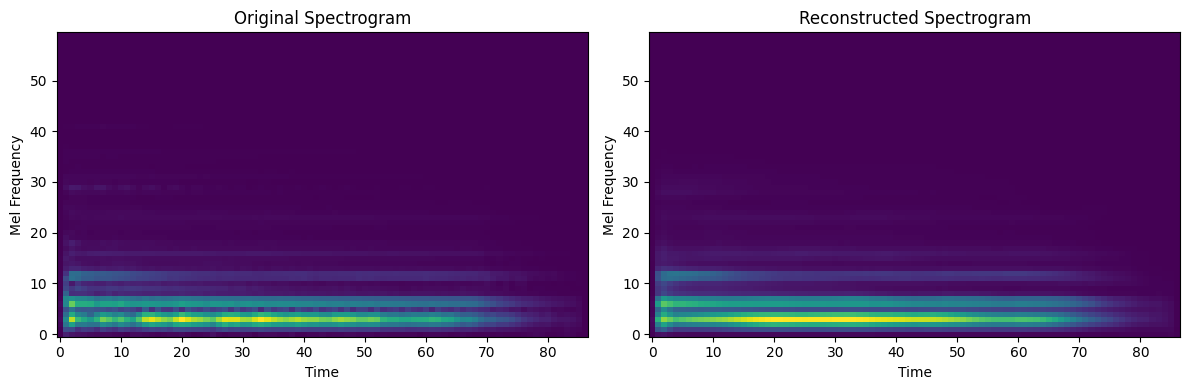

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot original spectrogram
axes[0].imshow(X.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='viridis')
axes[0].set_title('Original Spectrogram')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Mel Frequency')

# Plot reconstructed spectrogram
axes[1].imshow(X_reconstructed.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='viridis')
axes[1].set_title('Reconstructed Spectrogram')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Mel Frequency')

plt.tight_layout()
plt.show()

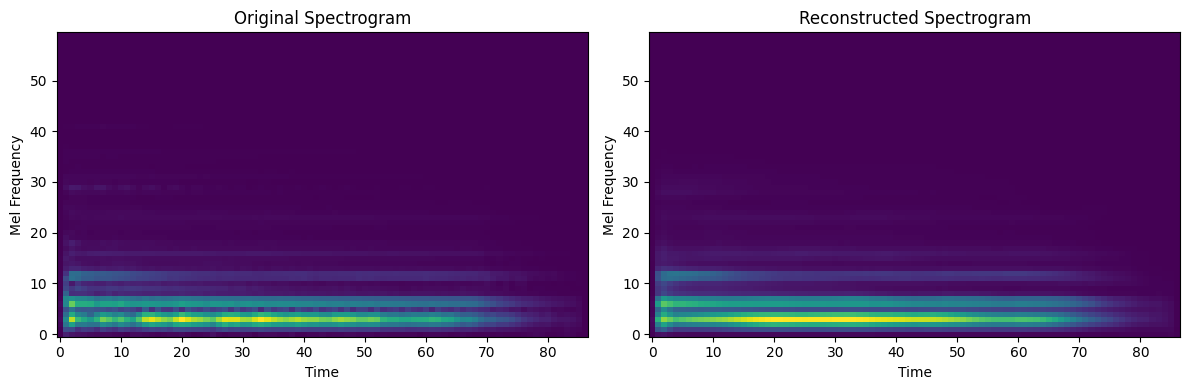

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot original spectrogram
axes[0].imshow(X.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='viridis')
axes[0].set_title('Original Spectrogram')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Mel Frequency')

# Plot reconstructed spectrogram
axes[1].imshow(X_reconstructed.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='viridis')
axes[1].set_title('Reconstructed Spectrogram')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Mel Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# v39
# "mse_weight": 100.,
# "kl_weight": 0.1,
# "warmup_epochs": 20,
# 1000 epochs

# v39
# "mse_weight": 100.,
# "kl_weight": 0.01,
# "warmup_epochs": 20,
# 700 epochs



In [85]:
def reconstruct_waveform(idx: int) -> tuple[np.ndarray, np.ndarray]:
    X = dataset[idx][0].unsqueeze(0)
    X_reconstructed = vae_lit.model(X)
    # X_reconstructed[X_reconstructed == 1] = 0
    waveform_recon = reconstruct_transform(X_reconstructed.squeeze(0).detach())
    waveform_orig = dataset.get_audio(idx).numpy()
    return waveform_recon, waveform_orig

In [86]:
for i in range(len(dataset)):
    waveform_recon, waveform_orig = reconstruct_waveform(i)
    display(Audio(waveform_recon, rate=sr))

In [58]:
import torch
import soundfile as sf

reconstructed_dir = top_folder / "data/tiny_piano/reconstructed"
reconstructed_dir.mkdir(parents=True, exist_ok=True)

for idx in range(19):
    wave_recon, wave_orig = reconstruct_waveform(idx)
    if isinstance(wave_recon, torch.Tensor):
        wave_recon = wave_recon.detach().numpy()
    sf.write(reconstructed_dir / f"orig_{idx}.wav", wave_orig, sr)
    sf.write(reconstructed_dir / f"recon_{idx}.wav", wave_recon, sr)

## Generate from latent

In [57]:
class GenDecoder(torch.nn.Module):
    def __init__(self, vae_decoder: nn.Module, inverse_transform: nn.Module):
        super().__init__()
        self.vae_decoder = vae_decoder
        self.inverse_transform = inverse_transform

    def forward(self, x):
        decoded = self.vae_decoder(x)
        return self.inverse_transform(decoded.detach())

In [58]:
gen_decoder = GenDecoder(vae_lit.model.decoder, reconstruct_transform)

In [65]:
def generate_from_random_latent():
    latent_dim = vae_config.latent_space_dim
    random_latent = torch.randn(1, latent_dim)
    generated_waveform = gen_decoder(random_latent)
    return generated_waveform

In [66]:
# latent = torch.randn(1, vae_config.latent_space_dim)
# X_decoded = vae_lit.model.decoder(latent)
# wave_decoded = reconstruct_transform(X_decoded.squeeze(0).detach())

wave_decoded = generate_from_random_latent()

In [61]:
# fig, axes = plt.subplots(1, 1, figsize=(6, 4))
# # Plot reconstructed spectrogram
# axes.imshow(X_gen.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='viridis')
# axes.set_title('Reconstructed Spectrogram')
# axes.set_xlabel('Time')
# axes.set_ylabel('Mel Frequency')

# plt.tight_layout()
# plt.show()

In [67]:
display(Audio(wave_decoded, rate=sr))

In [57]:
for idx in range(19):
    wave_gen = generate_from_random_latent()[0]
    if isinstance(wave_gen, torch.Tensor):
        wave_gen = wave_gen.detach().numpy()
    sf.write(reconstructed_dir / f"gen_{idx}.wav", wave_gen, sr)